## Feature Engineering

In this notebook, we shall work on the cleaned data set and try to prepare the features so that we can apply linear regression and other regression methods to them.

We start of by importing some necessary packages.

In [77]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from scipy import stats
from scipy.stats import norm, skew

from pathlib import Path
from config import COUNTRIES

We set up our data paths. We had already cleaned the data using the `clean.py` file in the `src` module.

These files are named after their countries and present in the `data/clean` directory.

In [78]:
path = Path.cwd()
cleaned_data_path = path.parent / 'data' / 'cleaned'

### Making Dataframes from the .csv files

`df`, here, contrary to conventional use, doesn't refer to the name of a pandas dataframe. Instead it is a dictionary of pandas dataframes. The key is the country name and the value is the cleaned dataframe corresponding to that country.

In [79]:
df = {}
for country in COUNTRIES :
    file_path = cleaned_data_path / (country+'.csv')
    df[country] = pd.read_csv(file_path)

### Feature engineering for germany

We will start off with feature engineering for just one country. If you notice, all the data in all the files are pretty similar. It is after all the same data, but for different countries. What we deduce from the dataframe for *Germany*, we shall implement for all other countries.

Our very first step is to create some new features.

What we start off with is find out which features have the maximumu correlation with our target variable that is incidence and then creating polynomial features from that feature.

We get the correlation matrix.

In [80]:
corr = df['germany'].corr()
corr['incidence'].sample(5)

Saegesser-Zeichen      -0.017794
Allgemeininfektion      0.273711
Intelligenzminderung    0.389284
Hamman-Zeichen         -0.036524
Keratolyse             -0.122371
Name: incidence, dtype: float64

We now have to sort this list in descending order so as to get the features with the maximun correlation to incidence

In [81]:
corr.sort_values(['incidence'], ascending = False, inplace = True)
corr['incidence'].head(11)

incidence                      1.000000
Schüttelfrost                  0.597271
Erkältung                      0.524202
Bradykardie                    0.509491
FSME-Impfstoff                 0.447844
Pertussisimpfstoff             0.397472
Totimpfstoff                   0.396158
Lebendimpfstoff                0.393729
Lungenentzündung               0.391089
Intelligenzminderung           0.389284
Potato-Spindle-Tuber-Viroid    0.374255
Name: incidence, dtype: float64

We will proceed with creating polynomials on the top 10 important features. Here we assume that importance of a feature is directly proportionality to its correlation to the target variable (incidence)


We will be synthesizing three new features each. One is a square feature, one cubic and one square root feature, adding suffixes of `-s2` and `-s3` and `-sq`  respectively.

In [82]:
count = 0
for column, correlation in corr['incidence'].items() :
    if count > 10:
        break
    if column == 'incidence' or column == 'week' or column == 'date':
        continue
    df['germany'][column+'-s2'] = df['germany'][column] ** 2
    df['germany'][column+'-s3'] = df['germany'][column] ** 3
    df['germany'][column+'-sq'] = np.sqrt(df['germany'][column])
    count += 1

Now We have all the features we need. However, all the features are skewed. For linear regression it is preferrable that all the features have a normal distribution. There are several ways to normalize.

But before we do this, we have to find out which features are numerical features are which are categorical features as we can only apply these normal transforms to the numerical features.

In [83]:
numerical_features = df['germany'].select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop('incidence')
numerical_features.shape

(332,)

Now we shall try to find out which of the features are actually skewed.
We gotta find out the skewness of each of the features.

In [84]:
skewness = df['germany'][numerical_features].apply(lambda x: skew(x))
skewness.describe()

count    332.000000
mean       2.084384
std        2.990377
min       -1.094021
25%        0.311920
50%        1.301025
75%        2.227899
max       17.440445
dtype: float64

We will only try to apply normalization to those features where the skewness is more than 0.5 or less than -0.5.

In [85]:
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to transform")

246 skewed numerical features to transform


In [86]:
skewed_features = skewness.index
skewed_features

Index(['Achsensymptom', 'Adenovirusimpfstoff', 'Adipsie', 'Aggravation',
       'Akantholyse', 'Akroosteolyse', 'Akute_Bronchitis',
       'Akute_Mittelohrentzündung', 'Akute_eitrige_Thyreoiditis', 'Alkalose',
       ...
       'Lungenentzündung-s3', 'Lungenentzündung-sq', 'Intelligenzminderung-s2',
       'Intelligenzminderung-s3', 'Potato-Spindle-Tuber-Viroid-s2',
       'Potato-Spindle-Tuber-Viroid-s3', 'Potato-Spindle-Tuber-Viroid-sq',
       'Akute_Mittelohrentzündung-s2', 'Akute_Mittelohrentzündung-s3',
       'Akute_Mittelohrentzündung-sq'],
      dtype='object', length=246)

We cannot apply the box-cox transformation here as it requires all values to be positive. However, as we know, several features which have a value of zero.

As a result, we shall try to use the Leo Johnson transform.
For non-negative values, the leo-johnson transform is defined as the box-cox transform after adding one to the features.

One important thing to keep in mind here is that we have to store the respective lambdas for each of the features.
For this we make a dictionary called lmbda.

In [87]:
lmbda = {'austria': {}, 'belgium': {}, 'germany': {}, 'italy': {}, 'netherlands': {}}
for feature in skewed_features:
    feature_data = df['germany'][feature] + 1
    feature_data, lmbda['germany'][feature] = stats.boxcox(feature_data)
    feature_data = pd.Series(feature_data)
    df['germany'][feature] = feature_data

Lets check for the skewness of features once we have applied this transformation.

In [88]:
skewness = df['germany'][numerical_features].apply(lambda x: skew(x))
skewness.describe()

count    332.000000
mean       0.326353
std        0.457394
min       -0.547741
25%       -0.016284
50%        0.292893
75%        0.666706
max        1.934249
dtype: float64

As we can see there has been quite a considerable improvement in the skewness values for each of the features due to the Leo-Johnson transform.

Let's see what the means and standard deviations of all the values are like now:

In [89]:
df['germany'].describe()

,incidence,Acetaldehydsyndrom,Achsensymptom,Adeno-assoziierte_Viren,Adenovirusimpfstoff,Adipsie,Adynamie,Aggravation,Akantholyse,Akroosteolyse,...,Lungenentzündung-sq,Intelligenzminderung-s2,Intelligenzminderung-s3,Intelligenzminderung-sq,Potato-Spindle-Tuber-Viroid-s2,Potato-Spindle-Tuber-Viroid-s3,Potato-Spindle-Tuber-Viroid-sq,Akute_Mittelohrentzündung-s2,Akute_Mittelohrentzündung-s3,Akute_Mittelohrentzündung-sq
count,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,...,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000
mean,3.665609,81.647436,0.209273,123.201923,0.285188,10.354945,226.548077,33.756336,38.949545,0.406952,...,1.117588,187.602816,281.410881,30.451706,5.002376,7.491898,1.685736,2.430851,3.607043,0.779711
std,7.651979,59.323822,0.280753,43.955191,0.408507,3.672148,111.740099,8.771337,12.896814,0.594587,...,1.014515,67.499381,101.252519,9.545524,2.577117,3.865136,0.855980,2.630680,3.938547,0.780824
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040000,27.750000,0.000000,100.000000,0.000000,7.998256,163.000000,31.419113,32.343446,0.000000,...,0.000000,141.463632,212.199931,24.315618,4.345779,6.503651,1.515585,0.000000,0.000000,0.000000
50%,0.475000,84.000000,0.000000,119.000000,0.000000,9.622394,210.500000,34.703199,37.336250,0.000000,...,1.176112,184.334229,276.507845,30.315008,5.051541,7.568143,1.694617,1.971210,2.865109,0.818509
75%,3.467500,116.250000,0.559003,143.250000,0.847109,13.331654,289.000000,37.000390,45.342981,1.217957,...,2.019986,221.168224,331.760626,35.305635,5.706996,8.553240,1.873077,5.288349,7.904089,1.545030
max,57.310000,252.000000,0.691035,289.000000,0.947107,18.676087,536.000000,122.857072,88.016196,1.390181,...,2.636966,328.747906,493.135679,49.254441,11.488337,17.212264,4.009091,6.514805,9.723606,1.966863


Although the skewness has been greatlyreduced, as we can see, the values of mean and standard deviations are very scattered. As a result, some features will be given a greater importance as compared to others. As a result what we have to do is scale the features such that the mean becomes 0 and the standard deviation becomes 1.

This is called the standard normal form.

In [90]:
for feature in numerical_features:
    feature_data = df['germany'][feature]
    feature_data -= feature_data.mean()
    feature_data /= feature_data.std()
    df['germany'][feature] = feature_data

In [91]:
df_germany = df['germany']
df['germany'].describe()

,incidence,Acetaldehydsyndrom,Achsensymptom,Adeno-assoziierte_Viren,Adenovirusimpfstoff,Adipsie,Adynamie,Aggravation,Akantholyse,Akroosteolyse,...,Lungenentzündung-sq,Intelligenzminderung-s2,Intelligenzminderung-s3,Intelligenzminderung-sq,Potato-Spindle-Tuber-Viroid-s2,Potato-Spindle-Tuber-Viroid-s3,Potato-Spindle-Tuber-Viroid-sq,Akute_Mittelohrentzündung-s2,Akute_Mittelohrentzündung-s3,Akute_Mittelohrentzündung-sq
count,312.000000,312.000000,312.000000,3.120000e+02,3.120000e+02,3.120000e+02,3.120000e+02,3.120000e+02,3.120000e+02,312.000000,...,3.120000e+02,3.120000e+02,3.120000e+02,3.120000e+02,312.000000,3.120000e+02,3.120000e+02,3.120000e+02,3.120000e+02,3.120000e+02
mean,3.665609,0.000000,0.000000,-6.832142e-17,-4.554761e-17,-5.465713e-16,-9.109522e-17,-3.074464e-16,9.109522e-17,0.000000,...,9.109522e-17,3.188333e-16,5.921189e-16,-1.366428e-16,0.000000,-1.821904e-16,-9.109522e-17,1.821904e-16,-9.109522e-17,1.366428e-16
std,7.651979,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000,-1.376301,-0.745399,-2.802898e+00,-6.981225e-01,-2.819861e+00,-2.027455e+00,-3.848483e+00,-3.020090e+00,-0.684428,...,-1.101598e+00,-2.779326e+00,-2.779298e+00,-3.190156e+00,-1.941074,-1.938327e+00,-1.969363e+00,-9.240388e-01,-9.158308e-01,-9.985752e-01
25%,0.040000,-0.908529,-0.745399,-5.278540e-01,-6.981225e-01,-6.417739e-01,-5.687133e-01,-2.664615e-01,-5.122272e-01,-0.684428,...,-1.101598e+00,-6.835497e-01,-6.835479e-01,-6.428236e-01,-0.254780,-2.556822e-01,-1.987793e-01,-9.240388e-01,-9.158308e-01,-9.985752e-01
50%,0.475000,0.039656,-0.745399,-9.559561e-02,-6.981225e-01,-1.994884e-01,-1.436197e-01,1.079496e-01,-1.250925e-01,-0.684428,...,5.768671e-02,-4.842395e-02,-4.842385e-02,-1.432065e-02,0.019078,1.972640e-02,1.037559e-02,-1.747231e-01,-1.883776e-01,4.968868e-02
75%,3.467500,0.583283,1.245687,4.561026e-01,1.375547e+00,8.106180e-01,5.589034e-01,3.698471e-01,4.957376e-01,1.363982,...,8.894872e-01,4.972699e-01,4.972691e-01,5.085031e-01,0.273414,2.745937e-01,2.188625e-01,1.086220e+00,1.091023e+00,9.801423e-01
max,57.310000,2.871571,1.715966,3.771979e+00,1.620336e+00,2.266015e+00,2.769390e+00,1.015817e+01,3.804556e+00,1.653636,...,1.497640e+00,2.091058e+00,2.091057e+00,1.969796e+00,2.516750,2.514884e+00,2.714263e+00,1.552433e+00,1.553000e+00,1.520383e+00


Also transforming the incidence(applying the Leo Johnson Transform)

We need to first see what the condition of the data is before we apply any transformation:


 mu = 3.67 and sigma = 7.64

skewness is:	3.7579859389207195


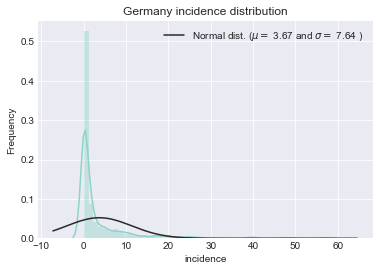

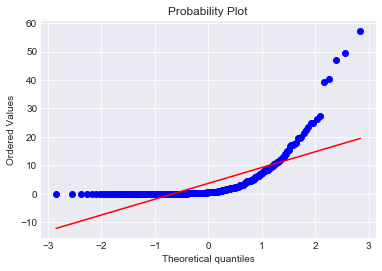

In [92]:
incidence_data = df['germany']['incidence']
sns.distplot(incidence_data , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(incidence_data)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Germany incidence distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(incidence_data, plot=plt)
plt.show()

print('skewness is:\t' + str(incidence_data.skew()))


 mu = 0.47 and sigma = 0.44

skewness after yeojohnson is:	0.41976583970488685
lambda after yeojohnson is:	-0.7479037568078828


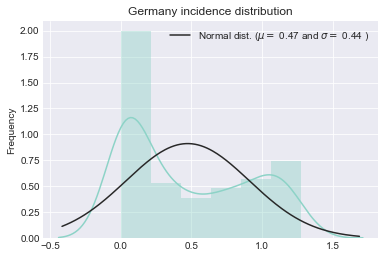

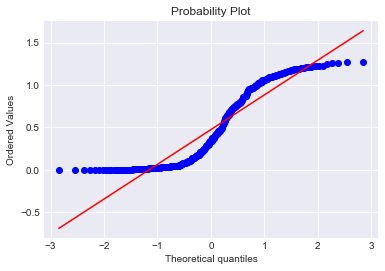

In [93]:
incidence_data = df['germany']['incidence'] + 1
incidence_data, lmbda_incidence = stats.boxcox(incidence_data)
incidence_data = pd.Series(incidence_data)

#Check the new distribution
sns.distplot(incidence_data , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(incidence_data)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Germany incidence distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(incidence_data, plot=plt)
plt.show()

print('skewness after yeojohnson is:\t' + str(incidence_data.skew()))
print('lambda after yeojohnson is:\t' + str(lmbda_incidence))

df['germany']['incidence'] = incidence_data
lmbda['germany']['incidence'] = lmbda_incidence

We have successfully normalized and scaled all the numerical features.

Now we have to deal with the week. This is a categorical variable which we will one hot encode.

This is swhat the week column looks like:

In [94]:
df['germany']['week'].sample(5)

259    2017-15
23     2008-13
225    2016-07
203    2015-11
182    2014-42
Name: week, dtype: object

What we have to do to this is first get the week number as an integer. For that we will get the last two characters of this string.

In [95]:
week_number = []
for index, row in df['germany'].iterrows():
    week_number.append(row['week'][-2:])
df['germany']['week_number'] = week_number
df['germany']['week_number'].sample(5)

237    45
50     14
124    10
84     48
161    47
Name: week_number, dtype: object

one hot encoding week numbers:

In [96]:
one_hot_encoded_weeks = pd.get_dummies(df['germany']['week_number'], prefix='week')
one_hot_encoded_weeks.sample(5)

,week_01,week_02,week_03,week_04,week_05,week_06,week_07,week_08,week_09,week_10,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
280,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
265,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
93,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


finally all we have left to do is merge the two dataframes into one and drop the `week_number` column.

In [97]:
df['germany'] = pd.concat([df['germany'], one_hot_encoded_weeks], axis=1)
df['germany'] = df['germany'].drop(columns=['week_number'])

We are done with features engineering for germany.

Now we will do the same thing for all the countries:
But first, let's define a few functions that will help us out:

In [98]:
def add_polynomial_features(country, df, num):
    # find the correlation matrix.
    correlation_matrix = df[country].corr()
    correlation_matrix.sort_values(['incidence'], ascending=False,
                                   inplace=True)

    count = 0
    for column, correlation in correlation_matrix['incidence'].items():
        if count > num:
            break
        if column == 'incidence' or column == 'week' or column == 'date':
            continue
        df[country][column + '-s2'] = df[country][column] ** 2
        df[country][column + '-s3'] = df[country][column] ** 3
        df[country][column + '-sq'] = np.sqrt(df[country][column])
        count += 1

In [99]:
def train_leo_johnson(df, lmbda, skewed_features):
    for feature in skewed_features:
        column = df[feature] + 1
        column, lmbda[feature] = stats.boxcox(column)
        column = pd.Series(column)
        df[feature] = column

In [100]:
def train_std_normal(df, numerical_features, means, std_deviations):
    for feature in numerical_features:
        column = df[feature]
        means[feature] = column.mean()
        std_deviations[feature] = column.std()
        column -= means[feature]
        column /= std_deviations[feature]
        df[feature] = column

In [101]:
def hot_encode_weeks(country, df):
    week_number = []
    for index, row in df[country].iterrows():
        week_number.append(row['week'][-2:])
    df[country]['week_number'] = week_number
    one_hot_encoded_weeks = pd.get_dummies(df[country]['week_number'],
                                           prefix='week')
    df[country] = pd.concat([df[country], one_hot_encoded_weeks], axis=1)
    df[country].drop(columns=['week_number'])

In [102]:
for country in COUNTRIES:
    if country == 'germany': continue;

    add_polynomial_features(country, df, 10)

    # separate numerical features from categorical ones
    numerical_features = df[country].select_dtypes(exclude=["object"]).columns
    numerical_features = numerical_features.drop('incidence')

    # skewness of >0.5 can be considered to be moderately skewed.
    skewness = df[country][numerical_features].apply(lambda x: skew(x))
    skewness = skewness[abs(skewness) > 0.5]
    skewed_features = skewness.index
    train_leo_johnson(df[country], lmbda[country], skewed_features)

    means = {}
    std_deviations = {}
    train_std_normal(df[country], numerical_features, means, std_deviations)

    # apply yeo johnson to incidence too
    train_leo_johnson(df[country], lmbda[country], ['incidence'])

    hot_encode_weeks(country, df)

/home/tejsukhatme/anaconda3/envs/python3.5/lib/python3.5/site-packages/scipy/stats/morestats.py:900: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/home/tejsukhatme/anaconda3/envs/python3.5/lib/python3.5/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/home/tejsukhatme/anaconda3/envs/python3.5/lib/python3.5/site-packages/scipy/optimize/optimize.py:1929: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/home/tejsukhatme/anaconda3/envs/python3.5/lib/python3.5/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/tejsukhatme/anaconda3/envs/python3.5/lib/python3.5/site-packages/scipy/optimize/optimize.py:1926: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)


And thus we conclude all the feature engineering that we will need to do for this dataset.